In [32]:
%matplotlib inline
import numpy as np
import glob
from os.path import join
from astropy.io import fits
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.ticker as ticker
from matplotlib.patches import Rectangle

## Measuring Crosstalk from Streaks

In [2]:
from matplotlib.colors import SymLogNorm
from matplotlib import colors

from lsst.obs.lsst import LsstCamMapper as camMapper
from lsst.obs.lsst.cameraTransforms import LsstCameraTransforms

from lsst.eotest.sensor.MaskedCCD import MaskedCCD
from lsst.eotest.sensor.spotTask import make_ccd_mosaic

from mixcoatl.crosstalk import make_stamp, crosstalk_fit, crosstalk_model, CrosstalkMatrix
from mixcoatl.crosstalkGenericTask import CrosstalkGenericTask

infile = 'E2V-CCD250-112-09_spot_spot_640_20200616234354.fits'

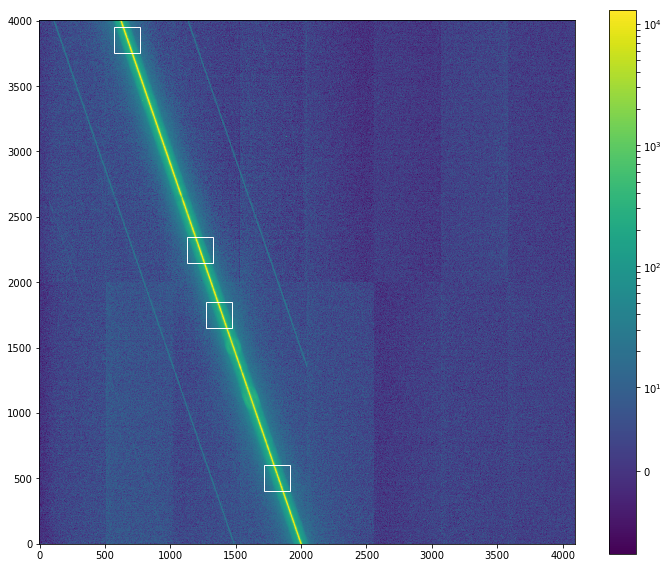

In [40]:
camera = camMapper._makeCamera()
lct = LsstCameraTransforms(camera)

image = make_ccd_mosaic(infile)
aggressor_coords = [(15, 150, 350),
                    (14, 1750, 300),
                    (3, 1750, 509-350),
                    (4, 500, 509-290)]

fig, ax = plt.subplots(1, 1, figsize=(12, 10))
im = ax.imshow(image.getArray(), origin='lower', norm=SymLogNorm(10, vmin=-10, vmax=13000))

l = 200.

for coord in aggressor_coords:
    amp, amp_y, amp_x = coord
    ccd_x, ccd_y = lct.ampPixelToCcdPixel(amp_x, amp_y, amp, 'R22_S11')
    ax.add_patch(Rectangle((ccd_x-l/2., ccd_y-l/2.), l, l, facecolor='none', edgecolor='white'))

fig.colorbar(im)

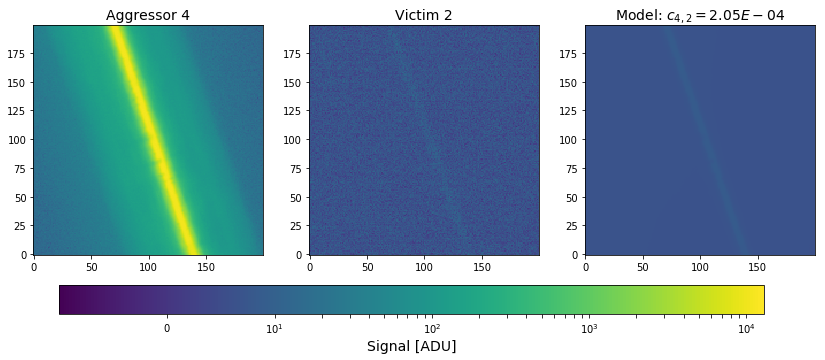

In [4]:
ccd = MaskedCCD(infile)

## Choose aggressor and victim
agg_amp = 4
aggarr = ccd.unbiased_and_trimmed_image(agg_amp).getImage().getArray()
vic_amp = 2
vicarr = ccd.unbiased_and_trimmed_image(vic_amp).getImage().getArray()

## Make stamps
l = 200
y, x = (500, 290)
aggressor_stamp = make_stamp(aggarr, y, x, l=l)
victim_stamp = make_stamp(vicarr, y, x, l=l)

## Best fit model
res = crosstalk_fit(aggressor_stamp, victim_stamp, num_iter=3, nsig=5.0, noise=7.0)
params = res[:4]
model = crosstalk_model(params, aggressor_stamp)

## Plot results
norm = SymLogNorm(10, vmin=-10, vmax=13000)

fig, axes = plt.subplots(1, 3, figsize=(14, 8))
im0 = axes[0].imshow(aggressor_stamp, origin='lower', norm=norm)
im1 = axes[1].imshow(victim_stamp, origin='lower', norm=norm)
im2 = axes[2].imshow(model, origin='lower', norm=norm)

axes[0].set_title(r'Aggressor {0}'.format(agg_amp), fontsize=14)
axes[1].set_title(r'Victim {0}'.format(vic_amp), fontsize=14)
axes[2].set_title(r'Model: $c_{{{0},{1}}}={2:.2E}$'.format(agg_amp, vic_amp, params[0]),
                  fontsize=14)

cbar_ax = fig.add_axes([0.15, 0.2, 0.7, 0.05])
cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal')
cbar.set_label('Signal [ADU]', fontsize=14)

In [6]:
sensor_id = 'Davis_e2v'
outfile = 'Davis_test.fits'
gains = {i : 1.0 for i in range(1, 17)}

aggressor_coords = [(15, 150, 350),
                    (14, 1750, 300),
                    (3, 1750, 350),
                    (4, 500, 290)]

crosstalk_task = CrosstalkGenericTask()
crosstalk_task.config.outfile = 'Davis_test.fits'

crosstalk_task.run('Davis_e2v', infile, aggressor_coords, gains)

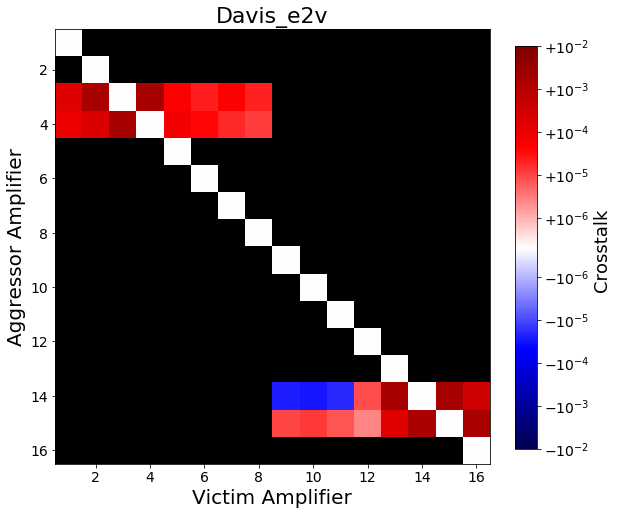

In [16]:
binned_cmap=False

fig, ax = plt.subplots(1, 1, figsize=(10, 8))

## Binned colormap
if binned_cmap:
    cmap = plt.cm.seismic
    cmaplist = [cmap(i) for i in range(cmap.N)]
    cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)
    cmap.set_bad(color='black')

    bounds = np.asarray([-1.0E-2, -1.0E-3,-1.0E-4,-1.0E-5,-1.0E-6, 
                          1.0E-6, 1.0E-5, 1.0E-4, 1.0E-3, 1.0E-2])
    norm = colors.BoundaryNorm(bounds, cmap.N)

    cbar_ticks = [-5.0E-3,-5.0E-4,-5.0E-5,-5.0E-6, 0., 
                   5.0E-6, 5.0E-5, 5.0E-4, 5.0E-3]
    cbar_ticklabels = [r'$-10^{-3}$', r'$-10^{-4}$', r'$-10^{-5}$', 
                       r'$-10^{-6}$', '0', r'$+10^{-6}$', 
                       r'$+10^{-5}$', r'$+10^{-4}$', r'$+10^{-3}$']

else:
    cmap = plt.cm.seismic
    cmap.set_bad(color='black')
    norm = colors.SymLogNorm(1E-6, vmin=-1.E-2, vmax=1E-2)
    cbar_ticks = [-1.0E-2, -1.0E-3,-1.0E-4,-1.0E-5,-1.0E-6, 
                   1.0E-6, 1.0E-5, 1.0E-4, 1.0E-3, 1.0E-2]
    cbar_ticklabels = [r'$-10^{-2}$', r'$-10^{-3}$', r'$-10^{-4}$', 
                       r'$-10^{-5}$', r'$-10^{-6}$', r'$+10^{-6}$', 
                       r'$+10^{-5}$', r'$+10^{-4}$', r'$+10^{-3}$', 
                       r'$+10^{-2}$']

with fits.open(outfile) as hdulist:
    xtalk = hdulist[1].data
    agg_amp = hdulist[0].header['AGGRESSOR']
np.fill_diagonal(xtalk, 0.0)
xtalk[:8, 8:] = np.nan
xtalk[8:, :8] = np.nan

im = ax.imshow(xtalk, norm=norm, cmap=cmap, interpolation='none', 
               extent=(0.5, 16.5, 16.5, 0.5))

ax.tick_params(axis='both', which='major', labelsize=14)
ax.set_ylabel('Aggressor Amplifier', fontsize=20)
ax.set_xlabel('Victim Amplifier', fontsize=20)
ax.set_title('{0}'.format(agg_amp), fontsize=22)

fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.85, 0.15, 0.03, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax, orientation='vertical', 
                    ticks=cbar_ticks)
cbar.ax.set_yticklabels(cbar_ticklabels)
cbar.set_label("Crosstalk ", size=18)
cbar.ax.tick_params(labelsize=14)

## Possible Streak Patterns

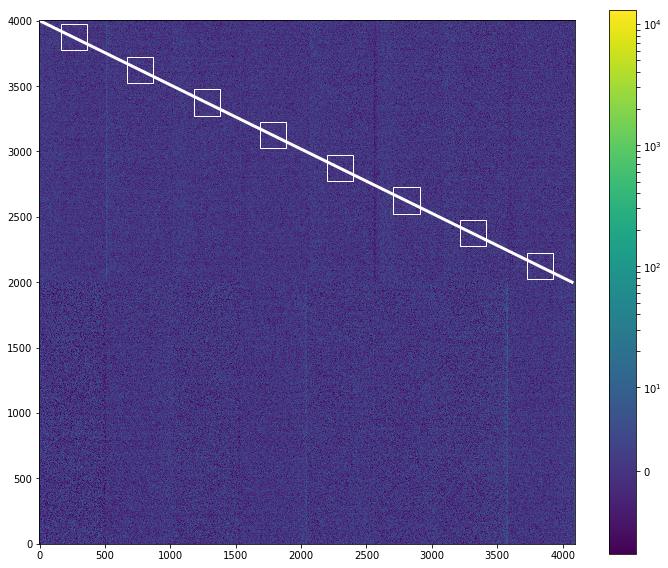

In [50]:
bias_file = 'R22_S11_superbias.fits'
image = make_ccd_mosaic(bias_file)

aggressor_coords = [(16-i, (i)*250+125, 250) for i in range(8)]

fig, ax = plt.subplots(1, 1, figsize=(12, 10))
im = ax.imshow(image.getArray(), origin='lower', norm=SymLogNorm(10, vmin=-10, vmax=13000))
ax.plot([0, 8*509], [4000, 2000], color='white', linewidth=3)

l = 200.

for coord in aggressor_coords:
    amp, amp_y, amp_x = coord
    ccd_x, ccd_y = lct.ampPixelToCcdPixel(amp_x, amp_y, amp, 'R22_S11')
    ax.add_patch(Rectangle((ccd_x-l/2., ccd_y-l/2.), l, l, facecolor='none', edgecolor='white'))
    
fig.colorbar(im)

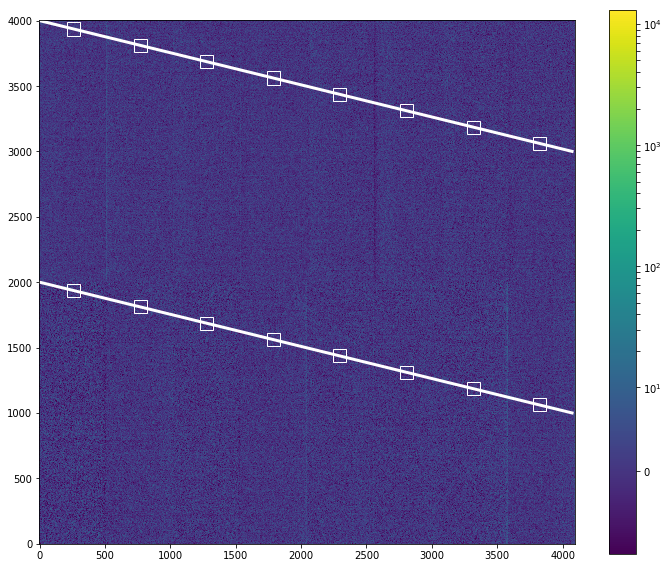

In [51]:
aggressor_coords = [(16-i, i*125+62.5, 250) for i in range(16)]

fig, ax = plt.subplots(1, 1, figsize=(12, 10))
im = ax.imshow(image.getArray(), origin='lower', norm=SymLogNorm(10, vmin=-10, vmax=13000))
ax.plot([0, 8*509], [4000, 3000], color='white', linewidth=3)
ax.plot([0, 8*509], [2000, 1000], color='white', linewidth=3)

l = 100.
for coord in aggressor_coords:
    amp, amp_y, amp_x = coord
    ccd_x, ccd_y = lct.ampPixelToCcdPixel(amp_x, amp_y, amp, 'R22_S11')
    ax.add_patch(Rectangle((ccd_x-l/2., ccd_y-l/2.), l, l, facecolor='none', edgecolor='white'))
    
fig.colorbar(im)